# EX-10-June-2024-Analysis

## Set up

In [1]:
# Standard python imports
import umap                     # dimension reduction
import pandas as pd             # working with tables & spreadsheets
import numpy as np              # working with matrices & numbers
import seaborn as sns           # visualization
import matplotlib.pyplot as plt # visualization


/home/machoi/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/machoi/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# Packages for working with text and embeddings
from langchain.embeddings import HuggingFaceEmbeddings # Embedding text to vectors
from sentence_transformers import SentenceTransformer, util #to calculate similarity

In [3]:
# Load results from experiment
dfLLM = pd.read_csv('EX-10-JUNE-2024-LLM-llama3-70b.csv')
dfRAG = pd.read_csv('EX-10-JUNE-2024-RAG-llama3-70b.csv')

# Represent Prompts as Vectors

In [4]:
# Load the embedder model
embedder = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')

/home/machoi/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/machoi/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
dfRAG['prompt'] # This is how you see all the prompts

0       Gene regulation is often described from the pe...
1       Gene regulation is often described from the pe...
2       Gene regulation is often described from the pe...
3       Gene regulation is often described from the pe...
4       Gene regulation is often described from the pe...
                              ...                        
2065    In nonlinear control theory, there are differe...
2066    In nonlinear control theory, there are differe...
2067    In nonlinear control theory, there are differe...
2068    In nonlinear control theory, there are differe...
2069    In nonlinear control theory, there are differe...
Name: prompt, Length: 2070, dtype: object

In [6]:
uniquePrompts = list(dfRAG['prompt'].unique()) # Get the unique prompts

In [7]:
# convert each prompt to an embedding
embeddings = []
for prompt in uniquePrompts:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)
print(len(embeddings[0]))

/home/machoi/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


768


In [8]:
# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()           # save umap results to a dataframe
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
udf['Prompt'] = uniquePrompts

/home/machoi/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/machoi/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


In [9]:
# makde some new columns in umap dataframe for number of words and length of each prompt
udf['len'] = udf['Prompt'].str.len()
udf['nwords'] = udf['Prompt'].str.split(' ').apply(len)

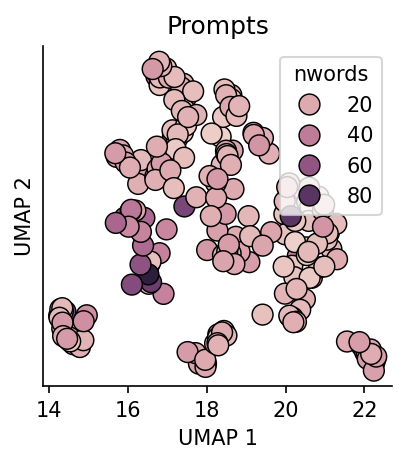

In [10]:
# visualize the prompt embeddings
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                hue='nwords',
                #palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                #legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
#plt.xticks([])
plt.yticks([])
sns.despine()
plt.show()


In [11]:
# What is this outlieing cluster?
udf[udf['UMAP 1'] > 5]

# Ah it is the set of prompts related to math

,UMAP 1,UMAP 2,Prompt,len,nwords
0,16.527084,2.848790,Gene regulation is often described from the pe...,382,58
1,16.900120,2.289071,Compare and contrast the utility of dynamical ...,257,37
2,17.430874,4.003430,Synthetic lethality occurs when the knockout o...,402,69
3,17.141191,5.395928,The addition of transcription factors have bee...,245,40
4,18.008572,3.148445,RNAi is used to silence different genes. How l...,153,27
...,...,...,...,...,...
202,16.077547,3.937479,Chromatin conformation capture methods are one...,273,42
203,16.013634,3.606310,I recently completed my Hi-C experiment and ha...,186,34
204,15.688565,3.680752,"Often, Hi-C data from chromatin conformation c...",326,50
205,14.950389,1.869179,"In nonlinear control theory, there are differe...",191,31


# Responses from LLM Only

In [12]:
# convert each prompt to an embedding
embeddings = []
for prompt in dfLLM['response-0']:
    embeddings.append(embedder.embed_query(prompt))
for prompt in dfLLM['response-1']:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)
print(embeddings.shape)

(414, 768)


In [13]:
# make umap embeddings
reducer = umap.UMAP(n_components=2, random_state=2)
embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()           # save umap results to a dataframe
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
udf['Prompt'] = list(dfLLM['response-0']) + list(dfLLM['response-1'])

/home/machoi/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


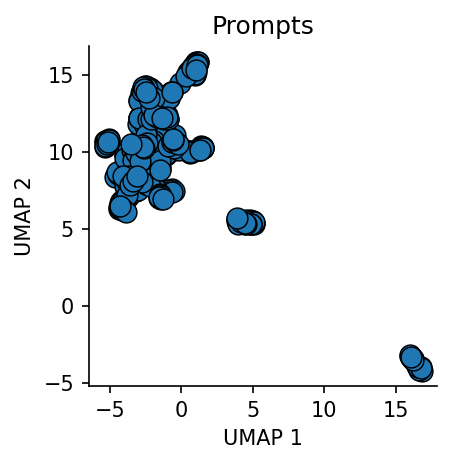

In [14]:
# visualize the prompt embeddings
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                #hue='nwords',
                #palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                #legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
#plt.xticks([])
#plt.yticks([])
sns.despine()
plt.show()

In [15]:
udf[(udf['UMAP 2'] < -4) & (udf['UMAP 1'] < 3)]

,UMAP 1,UMAP 2,Prompt


In [16]:
udf[udf['UMAP 2'] > 7]

,UMAP 1,UMAP 2,Prompt
0,-0.795827,10.389265,I don't know. The question is quite specific a...
1,-0.508393,11.015285,What a fascinating question!\n\nDynamical syst...
2,-1.546285,9.060222,These two ideas are related in that they both ...
3,-4.475158,8.602977,The relationship between transcription factor ...
4,-2.574024,8.501575,The duration of RNA interference (RNAi) gene s...
...,...,...,...
408,-0.675305,13.920862,There are several methods to deliver transcrip...
409,-1.401724,7.150062,"According to the context, polymer models, such..."
410,-1.585951,7.074240,Congratulations on completing your Hi-C experi...
412,-0.618908,10.807566,"I'd be happy to help!\n\nIn control theory, ob..."


In [17]:
udf[udf['UMAP 1'] > 10]

,UMAP 1,UMAP 2,Prompt
23,16.600540,-3.993419,I don't know.
62,16.016813,-3.238431,I don't have enough information to provide a s...
67,16.744514,-3.971726,I don't know.
105,16.660532,-4.052228,I don't know.
111,16.735573,-4.038409,I don't know.
112,16.089262,-3.306937,I don't have enough information to provide a s...
115,16.179714,-3.411871,I don't know the answer to this question as it...
127,16.735388,-4.161504,I don't know.
135,16.494623,-3.866020,"I don't know. The provided context is empty, a..."
137,16.628893,-4.012102,I don't know.


## Response Analysis

1. Compare query with responses and see if worst doc masked = best response
2. Compare responses with masked doc
3. Compare (2) and score between LLM w/o RAG and masked doc and see if RAG does better


In [18]:
number_of_responses = len(dfRAG['response'])
print(number_of_responses)
def cosine_sim(doc1, doc2):
    dotprod = np.dot(doc1, doc2)
    doc1norm = np.linalg.norm(doc1)
    doc2norm = np.linalg.norm(doc2)
    return (dotprod / (doc1norm*doc2norm))

2070


In [26]:
#objective 1
index = 0
sim_score = []
response_comp = []
hidden_means = []
for response in dfRAG['response']:
    question = dfRAG['prompt'][index]
    r_embedding = embedder.embed_query(response)
    r_embedding = np.array(r_embedding)
    q_embedding = embedder.embed_query(question)
    q_embedding = np.array(q_embedding)
    #append to lists to make into dataFrame
    sim_score.append(cosine_sim(r_embedding, q_embedding))
    response_comp.append(response)
    hidden_means.append((dfRAG['hiddenScore-0'][index]+dfRAG['hiddenScore-1'][index])/2)
    index += 1
scoring_df = pd.DataFrame({
    'Response': response_comp,
    'SimScore': sim_score,
    'hidden-mean': hidden_means
})
print(scoring_df)
confirmation = 0
number_of_questions = int(number_of_responses/10)
for i in range(0, number_of_questions):
    lower_bound = i*10
    upper_bound = (i)*10+9
    subset_score = scoring_df.loc[lower_bound:upper_bound]
    best_score = max(subset_score['SimScore'].tolist())
    worst_docs = min(subset_score['hidden-mean'].tolist())
    best_score_index = subset_score['SimScore'].tolist().index(best_score)
    worst_docs_index = subset_score['hidden-mean'].tolist().index(worst_docs)
    #best_score = subset_score['SimScore'].unstack().idxmax()
    #worst_docs = subset_score['hidden-mean'].unstack().idxmin()
    if best_score_index == worst_docs_index:
        confirmation += 1
print(f"Out of the {number_of_questions} questions, {confirmation} of the responses did the best with the best resources.")

                                               Response  SimScore  hidden-mean
0     Based on the provided context, it seems that t...  0.820625     0.767294
1     Based on the provided context, it seems that t...  0.838815     0.767906
2     Based on the provided context, it seems that t...  0.824021     0.770486
3     Based on the provided context, it seems that t...  0.780363     0.780678
4     Based on the provided context, it seems that t...  0.786614     0.783259
...                                                 ...       ...          ...
2065  In nonlinear control theory, controllability r...  0.839725     0.778345
2066  In nonlinear control theory, controllability r...  0.821966     0.781089
2067  I can help you with that!\n\nIn nonlinear cont...  0.842532     0.782072
2068  In nonlinear control theory, controllability r...  0.828482     0.782291
2069  In nonlinear control theory, controllability r...  0.817775     0.786732

[2070 rows x 3 columns]
Out of the 207 questions, 1

In [20]:
# Function to map values to inices
def map_values_to_indices(values, mapping):
    return [mapping[value] for value in values]

In [28]:
#Objective 2
index = 0
response_comp = []
hidden_score1 = []
hidden_score2 = []
hidden_score_comp1 = []
hidden_score_comp2 = []

for response in dfRAG['response']:
    r_embedding = embedder.embed_query(response)
    r_embedding = np.array(r_embedding)
    hidden1 = str(dfRAG['hiddenText-0'][index])
    hidden2 = str(dfRAG['hiddenText-1'][index])
    h_embedding1 = embedder.embed_query(hidden1)
    h_embedding1 = np.array(h_embedding1)
    h_embedding2 = embedder.embed_query(hidden2)
    h_embedding2 = np.array(h_embedding2)
    hidden1 = cosine_sim(r_embedding, h_embedding1)
    hidden2 = cosine_sim(r_embedding, h_embedding2)
    #append to lists to make into dataFrame
    response_comp.append(response)
    hidden_score1.append(dfRAG['hiddenScore-0'][index])
    hidden_score2.append(dfRAG['hiddenScore-1'][index])
    #comparison between response to masked doc
    hidden_score_comp1.append(hidden1)
    hidden_score_comp2.append(hidden2)
    index += 1
scoring_df = pd.DataFrame({
    'Response': response_comp,
    'hiddenScore-1': hidden_score1,
    'hiddenScore-2': hidden_score2,
    'hiddenScoreComp-1': hidden_score_comp1,
    'hiddenScoreComp-2': hidden_score_comp2
})
print(scoring_df)

                                               Response  hiddenScore-1  \
0     Based on the provided context, it seems that t...       0.769875   
1     Based on the provided context, it seems that t...       0.771098   
2     Based on the provided context, it seems that t...       0.771098   
3     Based on the provided context, it seems that t...       0.796643   
4     Based on the provided context, it seems that t...       0.796643   
...                                                 ...            ...   
2065  In nonlinear control theory, controllability r...       0.782787   
2066  In nonlinear control theory, controllability r...       0.790678   
2067  I can help you with that!\n\nIn nonlinear cont...       0.790678   
2068  In nonlinear control theory, controllability r...       0.790678   
2069  In nonlinear control theory, controllability r...       0.790678   

      hiddenScore-2  hiddenScoreComp-1  hiddenScoreComp-2  
0          0.764714           0.764708           0.

In [44]:
number_of_questions = int(number_of_responses/10)
match = 0
for i in range(0, number_of_questions):
    lower_bound = i*10
    upper_bound = (i)*10+9
    #look at each question individually
    subset_score = scoring_df.loc[lower_bound:upper_bound]
    column1 = subset_score['hiddenScore-1'].to_list()
    column2 = subset_score['hiddenScore-2'].to_list()
    all_values = column1 + column2
    distinct_values = list(set(all_values))
    value_to_index = {value: idx for idx, value in enumerate(distinct_values)}
    #print("Distinct values and their indices:", value_to_index)
    column1_indices = map_values_to_indices(column1, value_to_index)
    column2_indices = map_values_to_indices(column2, value_to_index)

    #print("Column 1 indices:", column1_indices)
    #print("Column 2 indices:", column2_indices)
    column1_score = subset_score['hiddenScoreComp-1'].to_list()
    column2_score = subset_score['hiddenScoreComp-2'].to_list()
    # Combine the indices into rows
    rows = list(zip(column1_indices, column2_indices))

    # Initialize dictionaries to store sums and counts for each index
    index_sums = {index: 0 for index in value_to_index.values()}
    index_counts = {index: 0 for index in value_to_index.values()}

# Accumulate sums and counts for column1_indices and column2_indices
    for idx, (c1_index, c2_index, score1, score2) in enumerate(zip(column1_indices, column2_indices, column1_score, column2_score)):
        index_sums[c1_index] += score1
        index_counts[c1_index] += 1
        index_sums[c2_index] += score2
        index_counts[c2_index] += 1

    # Compute the average for each index
    index_averages = {index: index_sums[index] / index_counts[index] for index in index_sums}

    #print("Index averages:", index_averages)
    inverted_dict = {value: key for key, value in value_to_index.items()}
    min_average = min(index_averages, key=index_averages.get)
    min_ref = min(inverted_dict, key=inverted_dict.get)
    #print("min average:", min_average)
    #print("min reference:", min_ref)
    if min_average == min_ref:
        match += 1
print(f"Out of the {number_of_questions} questions, {match} of the weakest document have on average the weakest response.")
    

Out of the 207 questions, 67 of the weakest document have on average the weakest response.


In [51]:
#objective 3
comparison = 0
avg_comparison = 0
for i in range(len(dfLLM['response-0'])):
    question = dfLLM['prompt'][i]
    response1 = dfLLM['response-0'][i]
    response2 = dfLLM['response-1'][i]
    response1 = embedder.embed_query(response1)
    response1 = np.array(response1)
    response2 = embedder.embed_query(response2)
    response2 = np.array(response2)
    
    hidden1 = str(dfRAG['hiddenText-0'][i])
    hidden2 = str(dfRAG['hiddenText-1'][i])
    h_embedding1 = embedder.embed_query(hidden1)
    h_embedding1 = np.array(h_embedding1)
    h_embedding2 = embedder.embed_query(hidden2)
    h_embedding2 = np.array(h_embedding2)
    hidden1 = cosine_sim(response1, h_embedding1)
    hidden2 = cosine_sim(response1, h_embedding2)
    hidden3 = cosine_sim(response2, h_embedding1)
    hidden4 = cosine_sim(response2, h_embedding2)

    #append to lists to make into dataFrame
    best_output = max(hidden1, hidden2, hidden3, hidden4)
    mean_output = (hidden1+ hidden2+ hidden3+ hidden4)/4
    if min(scoring_df['hiddenScoreComp-1'][i], scoring_df['hiddenScoreComp-2'][i]) > best_output:
        comparison += 1
    if ((scoring_df['hiddenScoreComp-1'][i]+ scoring_df['hiddenScoreComp-2'][i])/2) > mean_output:
        avg_comparison += 1
print(f"Out of the {number_of_responses} responses, {comparison} responses given by BRAD outpreform standard LLM absolutely.")
print(f"Out of the {number_of_responses} responses, {avg_comparison} responses given by BRAD outpreform standard LLM on average.")


Out of the 2070 responses, 190 responses given by BRAD outpreform standard LLM absolutely.
Out of the 2070 responses, 203 responses given by BRAD outpreform standard LLM on average.
